# Análise de Dados em Grafos
## Trabalho 01
- Aluno: José Freitas Alves Neto
- Matricula: 2519203

# Função de visualização / imports

In [244]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from networkx.algorithms import community
import pandas as pd
import unicodedata

def plotar_grafo_legivel(G,
                         title="Visualização de Grafo",
                         layout_type='spring', # 'spring', 'kamada_kawai', 'sfdp', 'neato', 'fdp'
                         node_size_base=50,
                         node_size_multiplier=10,
                         k_spring=0.25, # Aumentado em relação ao original (0.15)
                         iterations_spring=75, # Aumentado em relação ao original (50)
                         figsize=(15, 10), # Aumentado o tamanho da figura
                         seed=42):
    """
    Plota um grafo com detecção de comunidades e tenta reduzir a sobreposição de nós.

    Args:
        G (nx.Graph): O grafo a ser plotado.
        title (str): Título do gráfico.
        layout_type (str): Tipo de layout a ser usado. Opções:
                           'spring', 'kamada_kawai'.
                           Se pygraphviz ou pydot estiverem instalados: 'sfdp', 'neato', 'fdp'.
        node_size_base (int): Tamanho base dos nós.
        node_size_multiplier (int): Multiplicador para o tamanho do nó baseado no grau.
        k_spring (float): Parâmetro k para o spring_layout (distância ótima).
        iterations_spring (int): Número de iterações para o spring_layout.
        figsize (tuple): Tamanho da figura do matplotlib.
        seed (int): Semente para reprodutibilidade dos layouts baseados em força.
    """
    print(f"Tentando plotar com layout: {layout_type}")

    # 1. Detecção de Comunidades (como no seu código original)
    try:
        # Tenta o método mais recente se a versão do networkx for >= 2.4
        comunidades = list(nx.community.greedy_modularity_communities(G))
    except AttributeError: # Para versões mais antigas do networkx
        comunidades = list(community.greedy_modularity_communities(G)) # Seu import original

    mapa_comunidades = {}
    for i, c in enumerate(comunidades):
        for no in c:
            mapa_comunidades[no] = i
    num_comunidades = len(comunidades)
    if num_comunidades > 0:
        lista_cores = [mapa_comunidades.get(no, -1) for no in G.nodes()] # .get para segurança
        cmap = plt.cm.get_cmap('turbo', num_comunidades)
    else: # Caso nenhuma comunidade seja encontrada
        lista_cores = 'skyblue'
        cmap = None
        num_comunidades = 1 # Para evitar divisão por zero no cmap se não for usado


    # 2. Cálculo da Posição dos Nós (Layout)
    if layout_type == 'spring':
        pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed)
    elif layout_type == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    elif layout_type in ['sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo']:
        if HAS_PYGRAPHVIZ:
            print(f"Usando pygraphviz para layout '{layout_type}'")
            pos = nx.nx_agraph.graphviz_layout(G, prog=layout_type, args='-Goverlap=scale')
        elif HAS_PYDOT:
            print(f"Usando pydot para layout '{layout_type}'")
            # Pydot pode ser um pouco mais limitado em opções de 'args' diretamente
            # mas alguns layouts como 'sfdp' são muito bons em evitar overlap por padrão
            pos = nx.nx_pydot.graphviz_layout(G, prog=layout_type)
        else:
            print(f"Layout '{layout_type}' requer pygraphviz ou pydot. Voltando para 'spring'.")
            pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed)
    else:
        print(f"Layout '{layout_type}' desconhecido. Usando 'spring'.")
        pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed)

    # 3. Tamanho dos Nós
    lista_tamanho_nos = [node_size_base + node_size_multiplier * G.degree(no) for no in G.nodes()]

    # 4. Plotagem
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos,
                           node_size=lista_tamanho_nos,
                           node_color=lista_cores,
                           cmap=cmap,
                           linewidths=0.8, # Reduzido um pouco
                           edgecolors='black',
                           alpha=0.85) # Levemente reduzido para ver sobreposições sutis

    nx.draw_networkx_edges(G, pos,
                           alpha=0.3, # Reduzido para dar mais destaque aos nós
                           width=0.7) # Reduzido

    # Adicionar rótulos (opcional, mas se adicionar, eles também podem sobrepor)
    # Considere usar a biblioteca 'adjustText' se os rótulos forem um problema.
    # nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(title, fontsize=18) # Ajustado o tamanho da fonte
    plt.axis('off')
    plt.tight_layout() # Tenta ajustar para evitar que elementos saiam da figura
    plt.show()

def plotar_componente_conectado_com_destaque(
                                             G_original,
                                             target_node_name,
                                             title_prefix="Componente Conectado de",
                                             layout_type='spring',
                                             # --- PARÂMETROS CHAVE PARA ESPAÇAMENTO ---
                                             k_spring=0.5, # Para 'spring': Aumentar para mais espaçamento (ex: 0.6, 0.8, 1.2). Padrão ajustado de 0.3/0.4.
                                             spring_layout_scale=1.8, # Para 'spring' e 'kamada_kawai': Escala geral. Aumentar (ex: 1.5, 2.0, 2.5). Padrão ajustado de 1.0/1.5.
                                             graphviz_layout_args="-Goverlap=scale -splines=true -sep=0.8", # Para Graphviz: '-sep=X' (X em polegadas, ex: 0.7, 1.0, 1.5). Padrão ajustado.
                                             # -----------------------------------------
                                             iterations_spring=80, # Um pouco mais de iterações
                                             node_size_base=200, # Reduzido para nós menores por padrão
                                             node_size_multiplier=20, # Reduzido
                                             figsize=(20, 14), # Aumentado significativamente
                                             seed=42,
                                             target_node_color='red',
                                             neighbor_node_color='orange',
                                             other_node_community_cmap='turbo',
                                             default_other_node_color='lightgray',
                                             target_edge_color='red',
                                             other_edge_color='gray',
                                             target_node_size_add=400, # Reduzido um pouco para não dominar tanto
                                             neighbor_node_size_add=200, # Reduzido
                                             target_edge_width=2.0, # Ligeiramente mais fino
                                             other_edge_width=0.4,  # Ligeiramente mais fino
                                             label_font_size=7, # Reduzido para menos poluição com rótulos
                                             show_labels=True,
                                             label_bbox_alpha=0.3): # Transparência do fundo do rótulo
    """
    Plota o componente conectado de um nó alvo, destacando o nó e suas conexões diretas.
    Padrões ajustados para TENTAR gerar um grafo MAIS ESPALHADO.

    **Para obter um grafo AINDA mais espalhado (ou menos), experimente ajustar:**
    1.  `k_spring` (se layout_type='spring'): AUMENTE para mais espaçamento (ex: 0.7, 1.0, 1.5).
    2.  `spring_layout_scale` (para 'spring' ou 'kamada_kawai'): AUMENTE para mais espaçamento (ex: 2.0, 2.5).
    3.  `graphviz_layout_args`: Para layouts Graphviz ('sfdp', 'neato', etc.), AUMENTE o valor de `-sep`
        (ex: `graphviz_layout_args="-Goverlap=scale -splines=true -sep=1.2"`).
    4.  `figsize`: AUMENTE para dar mais espaço físico na tela (ex: (25, 18)).
    5.  `node_size_base` e `node_size_multiplier`: REDUZA para nós menores.
    6.  `label_font_size`: REDUZA se os rótulos estiverem se sobrepondo ou muito grandes.

    Args:
        G_original (nx.Graph): O grafo original completo.
        target_node_name (str): O nome do nó cujo componente conectado será plotado.
        layout_type (str): Tipo de layout ('spring', 'kamada_kawai', 'sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo').
        k_spring (float, optional): Parâmetro k para spring_layout. AUMENTE para mais espaçamento.
        spring_layout_scale (float): Fator de escala para spring_layout ou kamada_kawai. AUMENTE para mais espaçamento.
        graphviz_layout_args (str): Argumentos para layouts do Graphviz. Use '-sep=X' para separação.
        iterations_spring (int): Iterações para spring_layout.
        node_size_base (int): Tamanho base dos nós. REDUZA para nós menores.
        node_size_multiplier (int): Multiplicador de tamanho do nó pelo grau. REDUZA para nós menores.
        figsize (tuple): Tamanho da figura. AUMENTE para mais espaço.
        label_font_size (int): Tamanho da fonte dos rótulos. REDUZA se estiverem sobrepostos.
        ... (outros argumentos)
    """
    if target_node_name not in G_original:
        print(f"Erro: Nó '{target_node_name}' não encontrado no grafo original.")
        return

    component_nodes = None
    for comp in nx.connected_components(G_original):
        if target_node_name in comp:
            component_nodes = comp
            break

    if not component_nodes:
        print(f"Erro: Não foi possível encontrar o componente conectado para '{target_node_name}'.")
        return

    G_subgraph = G_original.subgraph(component_nodes).copy()

    num_nodes_subgraph = G_subgraph.number_of_nodes()
    num_edges_subgraph = G_subgraph.number_of_edges()

    if num_nodes_subgraph == 0:
        print(f"Aviso: O componente conectado de '{target_node_name}' está vazio. Nada para plotar.")
        return

    print(f"Plotando o componente conectado de '{target_node_name}' com {num_nodes_subgraph} nós e {num_edges_subgraph} arestas.")
    print(f"Layout: {layout_type}")
    if layout_type == 'spring':
        print(f"  k_spring: {k_spring}, iterations: {iterations_spring}, scale: {spring_layout_scale}")
    elif layout_type == 'kamada_kawai':
        print(f"  scale: {spring_layout_scale}")
    elif layout_type in ['sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo']:
        print(f"  Graphviz args: '{graphviz_layout_args}'")

    target_neighbors = list(G_subgraph.neighbors(target_node_name)) if G_subgraph.has_node(target_node_name) else []


    comunidades = []
    mapa_comunidades = {}
    num_comunidades = 0
    if community and num_nodes_subgraph > 1: # Detecção de comunidade só faz sentido com >1 nó
        try:
            # Tentar usar a versão mais recente do NetworkX para community detection
            if hasattr(nx.community, 'greedy_modularity_communities'):
                 comunidades_gen = nx.community.greedy_modularity_communities(G_subgraph)
            # Fallback para a biblioteca `community` (python-louvain)
            elif hasattr(community, 'greedy_modularity_communities'):
                 comunidades_gen = community.greedy_modularity_communities(G_subgraph)
            else:
                raise AttributeError("Nenhuma função greedy_modularity_communities encontrada.")

            comunidades = [list(c) for c in comunidades_gen] # Converter para lista de listas
            for i, c_nodes in enumerate(comunidades):
                for no_in_subgraph in c_nodes:
                    mapa_comunidades[no_in_subgraph] = i
            num_comunidades = len(comunidades)
        except Exception as e:
            print(f"Aviso: Não foi possível detectar comunidades: {e}. Os nós não serão coloridos por comunidade.")
            comunidades = []
            mapa_comunidades = {}
            num_comunidades = 0


    # Cálculo da Posição dos Nós (Layout para o subgrafo)
    pos = None
    # Para grafos com 1 nó, o layout pode não ser necessário ou dar erro.
    if num_nodes_subgraph == 1:
        # Coloca o único nó no centro
        node_list = list(G_subgraph.nodes())
        pos = {node_list[0]: (0.5, 0.5)}
    elif num_nodes_subgraph > 1:
        if layout_type == 'spring':
            pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale, center=None)
        elif layout_type == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(G_subgraph, scale=spring_layout_scale, center=None)
        elif layout_type in ['sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo']:
            use_prog = None
            if HAS_PYGRAPHVIZ: use_prog = "pygraphviz"
            elif HAS_PYDOT: use_prog = "pydot"

            if use_prog == "pygraphviz":
                try:
                    pos = nx.nx_agraph.graphviz_layout(G_subgraph, prog=layout_type, args=graphviz_layout_args)
                except Exception as e:
                    print(f"Erro ao usar pygraphviz com {layout_type} e args '{graphviz_layout_args}': {e}\nVoltando para 'spring'.")
                    pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
            elif use_prog == "pydot":
                try:
                    print(f"Aviso: Para Pydot, '{graphviz_layout_args}' pode não ser totalmente aplicado. PyGraphviz é recomendado para controle fino.")
                    pos = nx.nx_pydot.graphviz_layout(G_subgraph, prog=layout_type)
                except Exception as e:
                    print(f"Erro ao usar pydot com {layout_type}: {e}\nVoltando para 'spring'.")
                    pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
            else:
                print(f"Layout '{layout_type}' requer pygraphviz ou pydot. Voltando para 'spring'.")
                pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
        else:
            print(f"Layout '{layout_type}' desconhecido. Usando 'spring'.")
            pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)

    if pos is None and num_nodes_subgraph > 0 : # Fallback final se pos não foi definido
        print("Aviso: Posições não puderam ser calculadas, usando um spring_layout genérico.")
        pos = nx.spring_layout(G_subgraph, seed=seed)


    # Atributos Visuais
    node_colors_list = []
    node_sizes_list = []
    node_list_ordered = list(G_subgraph.nodes())

    cmap_obj = None
    if num_comunidades > 0:
        cmap_obj = plt.cm.get_cmap(other_node_community_cmap, num_comunidades if num_comunidades > 1 else 2)

    for node_val in node_list_ordered:
        if node_val == target_node_name:
            node_colors_list.append(target_node_color)
        elif node_val in target_neighbors:
            node_colors_list.append(neighbor_node_color)
        else:
            if cmap_obj and node_val in mapa_comunidades and num_comunidades > 1:
                community_index = mapa_comunidades[node_val]
                node_colors_list.append(cmap_obj(community_index / (num_comunidades - 1)))
            else:
                node_colors_list.append(default_other_node_color)

        degree = G_subgraph.degree(node_val) if G_subgraph.has_node(node_val) else 0
        current_base_size = node_size_base + node_size_multiplier * degree
        if node_val == target_node_name:
            node_sizes_list.append(current_base_size + target_node_size_add)
        elif node_val in target_neighbors:
            node_sizes_list.append(current_base_size + neighbor_node_size_add)
        else:
            node_sizes_list.append(current_base_size)

    edge_colors_list = []
    edge_widths_list = []
    for u, v in G_subgraph.edges():
        is_target_conn = (u == target_node_name and v in target_neighbors) or \
                         (v == target_node_name and u in target_neighbors)
        if is_target_conn:
            edge_colors_list.append(target_edge_color)
            edge_widths_list.append(target_edge_width)
        else:
            edge_colors_list.append(other_edge_color)
            edge_widths_list.append(other_edge_width)

    # Plotagem
    fig, ax = plt.subplots(figsize=figsize)

    if not pos and num_nodes_subgraph > 0: # Se ainda não há pos, não podemos desenhar
        ax.text(0.5, 0.5, "Não foi possível calcular as posições dos nós.", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    elif num_nodes_subgraph > 0 :
        nx.draw_networkx_nodes(G_subgraph, pos,
                               ax=ax,
                               nodelist=node_list_ordered,
                               node_size=node_sizes_list,
                               node_color=node_colors_list,
                               linewidths=0.7, # Borda sutil
                               edgecolors='black',
                               alpha=0.95)

        nx.draw_networkx_edges(G_subgraph, pos,
                               ax=ax,
                               edgelist=list(G_subgraph.edges()),
                               edge_color=edge_colors_list,
                               width=edge_widths_list,
                               alpha=0.6,
                               arrows=False)

        if show_labels:
            font_weights_map = {node: ('bold' if node == target_node_name or node in target_neighbors else 'normal') for node in G_subgraph.nodes()}
            for node_val in G_subgraph.nodes():
                if node_val not in pos: continue # Segurança
                x, y = pos[node_val]
                label_text = str(node_val)
                bbox_p = None
                if label_bbox_alpha > 0:
                    bbox_p = dict(boxstyle='round,pad=0.15', facecolor='white', alpha=label_bbox_alpha, edgecolor='none')

                ax.text(x, y, label_text, size=label_font_size,
                         weight=font_weights_map.get(node_val, 'normal'),
                         ha='center', va='center', zorder=5, # zorder para garantir que o texto fique em cima
                         bbox=bbox_p)

    ax.set_title(f"{title_prefix} '{target_node_name}'", fontsize=max(10, int(figsize[0]))) # Tamanho do título proporcional à figura
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def plotar_componente_conectado_simples(
                                        G_original,
                                        target_node_name,
                                        title_prefix="Componente Conectado de",
                                        layout_type='spring',
                                        # --- PARÂMETROS CHAVE PARA ESPAÇAMENTO ---
                                        k_spring=0.5, # Para 'spring': Aumentar para mais espaçamento (ex: 0.6, 0.8, 1.2). Padrão ajustado.
                                        spring_layout_scale=1.8, # Para 'spring' e 'kamada_kawai': Escala geral. Aumentar (ex: 1.5, 2.0, 2.5). NOVO PARÂMETRO.
                                        graphviz_layout_args="-Goverlap=scale -splines=true -sep=0.8", # Para Graphviz: '-sep=X' (X em polegadas, ex: 0.7, 1.0, 1.5). NOVO PARÂMETRO.
                                        # -----------------------------------------
                                        iterations_spring=80, # Aumentado ligeiramente
                                        node_size_base=150, # Reduzido para nós menores por padrão
                                        node_size_multiplier=15, # Reduzido
                                        figsize=(18, 12), # Aumentado significativamente
                                        seed=42,
                                        use_communities_for_color=True,
                                        community_cmap='turbo',
                                        default_node_color='skyblue',
                                        edge_color='gray',
                                        edge_width=0.5, # Ligeiramente mais fino
                                        label_font_size=7, # Reduzido para menos poluição
                                        show_labels=True,
                                        label_bbox_alpha=0.0 # Por padrão, sem bbox para manter a simplicidade. Aumente para adicionar.
                                        ):
    """
    Plota apenas o componente conectado de um nó alvo, sem destaque especial.
    Os nós podem ser coloridos por comunidade. Ajustado para TENTAR gerar um grafo MAIS ESPALHADO.

    **Para obter um grafo AINDA mais espalhado (ou menos), experimente ajustar:**
    1.  `k_spring` (se layout_type='spring'): AUMENTE para mais espaçamento (ex: 0.7, 1.0, 1.5).
    2.  `spring_layout_scale` (para 'spring' ou 'kamada_kawai'): AUMENTE para mais espaçamento (ex: 2.0, 2.5).
    3.  `graphviz_layout_args`: Para layouts Graphviz ('sfdp', 'neato', etc.), AUMENTE o valor de `-sep`
        (ex: `graphviz_layout_args="-Goverlap=scale -splines=true -sep=1.2"`).
    4.  `figsize`: AUMENTE para dar mais espaço físico na tela (ex: (25, 18)).
    5.  `node_size_base` e `node_size_multiplier`: REDUZA para nós menores.
    6.  `label_font_size`: REDUZA se os rótulos estiverem se sobrepondo ou muito grandes.
    7.  `label_bbox_alpha`: Aumente (ex: 0.3) para adicionar um fundo semi-transparente aos rótulos para melhor legibilidade,
        embora isso adicione um pouco de complexidade visual.

    Args:
        G_original (nx.Graph): O grafo original completo.
        target_node_name (str): O nome do nó cujo componente conectado será plotado.
        layout_type (str): 'spring', 'kamada_kawai', 'sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo'.
        k_spring (float): Parâmetro k para spring_layout. AUMENTE para mais espaçamento.
        spring_layout_scale (float): Escala para spring_layout ou kamada_kawai. AUMENTE para mais espaçamento.
        graphviz_layout_args (str): Argumentos para layouts do Graphviz. Use '-sep=X'.
        label_bbox_alpha (float): Transparência da caixa de fundo dos rótulos (0 para sem caixa).
        ... (outros argumentos)
    """
    if target_node_name not in G_original:
        print(f"Erro: Nó '{target_node_name}' não encontrado no grafo original.")
        return

    component_nodes = None
    for comp in nx.connected_components(G_original):
        if target_node_name in comp:
            component_nodes = comp
            break

    if not component_nodes:
        print(f"Erro: Não foi possível encontrar o componente conectado para '{target_node_name}'.")
        return

    G_subgraph = G_original.subgraph(component_nodes).copy()
    num_nodes_subgraph = G_subgraph.number_of_nodes()
    num_edges_subgraph = G_subgraph.number_of_edges()

    if num_nodes_subgraph == 0:
        print(f"O componente conectado de '{target_node_name}' está vazio. Nada para plotar.")
        return

    print(f"Plotando o componente conectado de '{target_node_name}' com {num_nodes_subgraph} nós e {num_edges_subgraph} arestas.")
    print(f"Layout: {layout_type}")
    if layout_type == 'spring':
        print(f"  k_spring: {k_spring}, iterations: {iterations_spring}, scale: {spring_layout_scale}")
    elif layout_type == 'kamada_kawai':
        print(f"  scale: {spring_layout_scale}")
    elif layout_type in ['sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo']:
        print(f"  Graphviz args: '{graphviz_layout_args}'")

    # 2. Cálculo da Posição dos Nós (Layout para o subgrafo)
    pos = None
    if num_nodes_subgraph == 1:
        node_list = list(G_subgraph.nodes())
        pos = {node_list[0]: (0.5, 0.5)} # Nó único no centro
    elif num_nodes_subgraph > 1:
        if layout_type == 'spring':
            pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale, center=None)
        elif layout_type == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(G_subgraph, scale=spring_layout_scale, center=None) # Adicionado scale
        elif layout_type in ['sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo']:
            use_prog = None
            if HAS_PYGRAPHVIZ: use_prog = "pygraphviz"
            elif HAS_PYDOT: use_prog = "pydot"

            if use_prog == "pygraphviz":
                try:
                    pos = nx.nx_agraph.graphviz_layout(G_subgraph, prog=layout_type, args=graphviz_layout_args) # Usando graphviz_layout_args
                except Exception as e:
                    print(f"Erro ao usar pygraphviz com {layout_type} e args '{graphviz_layout_args}': {e}\nVoltando para 'spring'.")
                    pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
            elif use_prog == "pydot":
                try:
                    print(f"Aviso: Para Pydot, '{graphviz_layout_args}' pode não ser totalmente aplicado. PyGraphviz é recomendado para controle fino.")
                    pos = nx.nx_pydot.graphviz_layout(G_subgraph, prog=layout_type)
                except Exception as e:
                    print(f"Erro ao usar pydot com {layout_type}: {e}\nVoltando para 'spring'.")
                    pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
            else:
                print(f"Layout '{layout_type}' requer pygraphviz ou pydot. Voltando para 'spring'.")
                pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
        else:
            print(f"Layout '{layout_type}' desconhecido. Usando 'spring'.")
            pos = nx.spring_layout(G_subgraph, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)

    if pos is None and num_nodes_subgraph > 0 : # Fallback final se pos não foi definido
        print("Aviso: Posições não puderam ser calculadas, usando um spring_layout genérico.")
        pos = nx.spring_layout(G_subgraph, seed=seed)

    # 3. Atributos Visuais (Cores e Tamanhos dos Nós)
    node_colors_for_draw = default_node_color
    final_cmap_for_draw = None

    if use_communities_for_color and num_nodes_subgraph > 1 and community:
        try:
            if hasattr(nx.community, 'greedy_modularity_communities'):
                 comunidades_gen = nx.community.greedy_modularity_communities(G_subgraph)
            elif hasattr(community, 'greedy_modularity_communities'):
                 comunidades_gen = community.greedy_modularity_communities(G_subgraph)
            else:
                raise AttributeError("Nenhuma função greedy_modularity_communities encontrada.")

            comunidades_list = [list(c) for c in comunidades_gen]

            if comunidades_list and any(comunidades_list):
                mapa_comunidades = {}
                for i, c_nodes in enumerate(comunidades_list):
                    for no_in_subgraph in c_nodes:
                        mapa_comunidades[no_in_subgraph] = i
                num_comunidades_detected = len(comunidades_list)

                if num_comunidades_detected > 0:
                    node_colors_for_draw = [mapa_comunidades.get(node, -1) for node in G_subgraph.nodes()]
                    final_cmap_for_draw = plt.cm.get_cmap(community_cmap, num_comunidades_detected if num_comunidades_detected > 1 else 2)
                else:
                    print("Nenhuma comunidade significativa detectada.") # Mensagem mais clara
            else:
                print("Nenhuma comunidade detectada ou comunidades vazias.")
        except Exception as e:
            print(f"Aviso: Não foi possível detectar/processar comunidades: {e}. Usando cor padrão.")
            node_colors_for_draw = default_node_color
            final_cmap_for_draw = None

    node_sizes_list = [node_size_base + node_size_multiplier * G_subgraph.degree(node) for node in G_subgraph.nodes()]

    # 4. Plotagem
    fig, ax = plt.subplots(figsize=figsize)

    if not pos and num_nodes_subgraph > 0:
        ax.text(0.5, 0.5, "Não foi possível calcular as posições dos nós.", ha='center', va='center', transform=ax.transAxes)
    elif num_nodes_subgraph > 0 :
        nx.draw_networkx_nodes(G_subgraph, pos,
                               ax=ax,
                               node_size=node_sizes_list,
                               node_color=node_colors_for_draw,
                               cmap=final_cmap_for_draw,
                               linewidths=0.6,
                               edgecolors='dimgray',
                               alpha=0.85)

        nx.draw_networkx_edges(G_subgraph, pos,
                               ax=ax,
                               edge_color=edge_color,
                               width=edge_width,
                               alpha=0.55)

        if show_labels:
            if label_bbox_alpha > 0 and pos: # Só desenha rótulos com bbox se alpha > 0 e pos existe
                for node_val in G_subgraph.nodes():
                    if node_val not in pos: continue
                    x, y = pos[node_val]
                    label_text = str(node_val)
                    bbox_p = dict(boxstyle='round,pad=0.15', facecolor='white', alpha=label_bbox_alpha, edgecolor='none')
                    ax.text(x, y, label_text, size=label_font_size,
                             ha='center', va='center', zorder=5, # zorder para texto sobre elementos
                             bbox=bbox_p, fontfamily='sans-serif')
            elif pos: # Se não bbox, usa o método padrão do networkx, mas ainda verifica se pos existe
                nx.draw_networkx_labels(G_subgraph, pos, ax=ax, font_size=label_font_size, font_family='sans-serif')

    ax.set_title(f"{title_prefix} '{target_node_name}' ({num_nodes_subgraph}", fontsize=max(10, int(figsize[0])))
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def remover_acentos(texto):
    """
    Remove acentos e cedilha de um texto.
    Ex: 'MENDONÇA' → 'MENDONCA', 'AÇÃO' → 'ACAO'
    """
    if not isinstance(texto, str):
        return texto
    texto = texto.replace('ç', 'c').replace('Ç', 'C')
    return ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )

def normalizar_e_agrupar_com_cedilha(data):
    import pandas as pd

    # Cria mapeamentos para index e colunas
    rename_index = {}
    rename_columns = {}

    # --- TRATAR INDEX ---
    for i in list(data.index):
        novo = remover_acentos(i)
        if novo != i:
            if novo in data.index:
                data.loc[novo] = data.loc[novo].add(data.loc[i], fill_value=0)
            else:
                rename_index[i] = novo

    # --- TRATAR COLUNAS ---
    for c in list(data.columns):
        novo = remover_acentos(c)
        if novo != c:
            if novo in data.columns:
                data[novo] = data[novo].add(data[c], fill_value=0)
            else:
                rename_columns[c] = novo

    # Renomear os que ainda não existem
    data = data.rename(index=rename_index)
    data = data.rename(columns=rename_columns)

    # Remover os que ainda têm acento ou cedilha
    def contem_acentos(texto):
        return texto != remover_acentos(texto)

    data = data[~data.index.to_series().apply(contem_acentos)]
    data = data.loc[:, ~data.columns.to_series().apply(contem_acentos)]

    return data

def plotar_grafo_legivel(G,
                         title="Visualização de Grafo",
                         layout_type='spring', # 'spring', 'kamada_kawai', 'sfdp', 'neato', 'fdp'
                         # --- PARÂMETROS CHAVE PARA ESPAÇAMENTO E RÓTULOS ---
                         k_spring=0.5,             # Para 'spring': Aumentar para mais espaçamento. Padrão ajustado.
                         spring_layout_scale=1.8,  # Para 'spring' e 'kamada_kawai': Escala geral. Aumentar para mais espaçamento. NOVO.
                         graphviz_layout_args="-Goverlap=scale -splines=true -sep=0.8", # Para Graphviz: '-sep=X'. NOVO.
                         show_labels=True,         # NOVO: Controla se os rótulos dos nós são mostrados.
                         label_font_size=7,        # NOVO: Tamanho da fonte dos rótulos. Reduzido por padrão.
                         label_bbox_alpha=0.3,     # NOVO: Transparência do fundo do rótulo (0 para sem caixa).
                         # ---------------------------------------------------
                         node_size_base=150,        # Reduzido para nós menores por padrão
                         node_size_multiplier=15,   # Reduzido
                         iterations_spring=80,      # Aumentado
                         figsize=(18, 12),          # Aumentado o tamanho da figura
                         seed=42):
    """
    Plota um grafo com detecção de comunidades, rótulos dos nós, e tenta reduzir a sobreposição.

    **Para obter um grafo AINDA mais espalhado (ou menos), experimente ajustar:**
    1.  `k_spring` (se layout_type='spring'): AUMENTE para mais espaçamento.
    2.  `spring_layout_scale` (para 'spring' ou 'kamada_kawai'): AUMENTE para mais espaçamento.
    3.  `graphviz_layout_args`: Para layouts Graphviz, AUMENTE o valor de `-sep`.
    4.  `figsize`: AUMENTE para dar mais espaço físico na tela.
    5.  `node_size_base` e `node_size_multiplier`: REDUZA para nós menores.
    6.  `label_font_size`: REDUZA se os rótulos estiverem se sobrepondo ou muito grandes.
    7.  `label_bbox_alpha`: Aumente (ex: 0.5) para um fundo mais opaco nos rótulos, ou 0 para desabilitar.

    Args:
        G (nx.Graph): O grafo a ser plotado.
        title (str): Título do gráfico.
        layout_type (str): 'spring', 'kamada_kawai', 'sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo'.
        k_spring (float): Parâmetro k para o spring_layout.
        spring_layout_scale (float): Fator de escala para spring_layout ou kamada_kawai.
        graphviz_layout_args (str): Argumentos para layouts do Graphviz.
        show_labels (bool): Se True, mostra os rótulos dos nós.
        label_font_size (int): Tamanho da fonte dos rótulos.
        label_bbox_alpha (float): Alpha da caixa de fundo dos rótulos (0 para sem caixa).
        ... (outros argumentos)
    """
    num_nodes_graph = G.number_of_nodes()
    num_edges_graph = G.number_of_edges()

    if num_nodes_graph == 0:
        print("Grafo vazio. Nada para plotar.")
        return

    print(f"Plotando grafo '{title}' com {num_nodes_graph} nós e {num_edges_graph} arestas.")
    print(f"Layout: {layout_type}")
    if layout_type == 'spring':
        print(f"  k_spring: {k_spring}, iterations: {iterations_spring}, scale: {spring_layout_scale}")
    elif layout_type == 'kamada_kawai':
        print(f"  scale: {spring_layout_scale}")
    elif layout_type in ['sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo']:
        print(f"  Graphviz args: '{graphviz_layout_args}'")


    # 1. Detecção de Comunidades
    lista_cores_nodes = 'skyblue' # Padrão
    cmap_nodes = None
    num_comunidades_detected = 0

    if num_nodes_graph > 1 and community:
        try:
            if hasattr(nx.community, 'greedy_modularity_communities'):
                 comunidades_gen = nx.community.greedy_modularity_communities(G)
            elif hasattr(community, 'greedy_modularity_communities'):
                 comunidades_gen = community.greedy_modularity_communities(G)
            else:
                raise AttributeError("Nenhuma função greedy_modularity_communities encontrada.")

            comunidades_list = [list(c) for c in comunidades_gen]

            if comunidades_list and any(comunidades_list):
                mapa_comunidades = {}
                for i, c_nodes in enumerate(comunidades_list):
                    for no_in_graph in c_nodes:
                        mapa_comunidades[no_in_graph] = i
                num_comunidades_detected = len(comunidades_list)

                if num_comunidades_detected > 0:
                    lista_cores_nodes = [mapa_comunidades.get(node, -1) for node in G.nodes()]
                    cmap_nodes = plt.cm.get_cmap('turbo', num_comunidades_detected if num_comunidades_detected > 1 else 2)
                else:
                    print("Nenhuma comunidade significativa detectada.")
            else:
                print("Nenhuma comunidade detectada ou comunidades vazias.")
        except Exception as e:
            print(f"Aviso: Não foi possível detectar/processar comunidades: {e}. Usando cor padrão para nós.")
            lista_cores_nodes = 'skyblue'
            cmap_nodes = None
    else:
        print("Detecção de comunidades não realizada (grafo muito pequeno ou biblioteca 'community' não disponível).")


    # 2. Cálculo da Posição dos Nós (Layout)
    pos = None
    if num_nodes_graph == 1:
        node_list = list(G.nodes())
        pos = {node_list[0]: (0.5, 0.5)} # Nó único no centro
    elif num_nodes_graph > 1:
        if layout_type == 'spring':
            pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale, center=None)
        elif layout_type == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(G, scale=spring_layout_scale, center=None)
        elif layout_type in ['sfdp', 'neato', 'fdp', 'dot', 'twopi', 'circo']:
            use_prog = None
            if HAS_PYGRAPHVIZ: use_prog = "pygraphviz"
            elif HAS_PYDOT: use_prog = "pydot"

            if use_prog == "pygraphviz":
                try:
                    pos = nx.nx_agraph.graphviz_layout(G, prog=layout_type, args=graphviz_layout_args)
                except Exception as e:
                    print(f"Erro ao usar pygraphviz com {layout_type} e args '{graphviz_layout_args}': {e}\nVoltando para 'spring'.")
                    pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
            elif use_prog == "pydot":
                try:
                    print(f"Aviso: Para Pydot, '{graphviz_layout_args}' pode não ser totalmente aplicado. PyGraphviz é recomendado para controle fino.")
                    pos = nx.nx_pydot.graphviz_layout(G, prog=layout_type)
                except Exception as e:
                    print(f"Erro ao usar pydot com {layout_type}: {e}\nVoltando para 'spring'.")
                    pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
            else:
                print(f"Layout '{layout_type}' requer pygraphviz ou pydot. Voltando para 'spring'.")
                pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)
        else:
            print(f"Layout '{layout_type}' desconhecido. Usando 'spring'.")
            pos = nx.spring_layout(G, k=k_spring, iterations=iterations_spring, seed=seed, scale=spring_layout_scale)

    if pos is None and num_nodes_graph > 0 : # Fallback final se pos não foi definido
        print("Aviso: Posições não puderam ser calculadas, usando um spring_layout genérico.")
        pos = nx.spring_layout(G, seed=seed)


    # 3. Tamanho dos Nós
    lista_tamanho_nos = [node_size_base + node_size_multiplier * G.degree(no) for no in G.nodes()]

    # 4. Plotagem
    fig, ax = plt.subplots(figsize=figsize)

    if not pos and num_nodes_graph > 0:
        ax.text(0.5, 0.5, "Não foi possível calcular as posições dos nós.", ha='center', va='center', transform=ax.transAxes)
    elif num_nodes_graph > 0:
        nx.draw_networkx_nodes(G, pos,
                               ax=ax,
                               node_size=lista_tamanho_nos,
                               node_color=lista_cores_nodes,
                               cmap=cmap_nodes,
                               linewidths=0.6,
                               edgecolors='dimgray', # Borda um pouco mais escura
                               alpha=0.9)

        nx.draw_networkx_edges(G, pos,
                               ax=ax,
                               alpha=0.4, # Mais transparente para focar nos nós
                               width=0.6,
                               edge_color='gray') # Cor explícita

        # Adicionar rótulos
        if show_labels and pos: # Verifica se pos existe
            if label_bbox_alpha > 0:
                for node_val in G.nodes():
                    if node_val not in pos: continue
                    x, y = pos[node_val]
                    label_text = str(node_val) # Garante que é string
                    bbox_p = dict(boxstyle='round,pad=0.15', facecolor='white', alpha=label_bbox_alpha, edgecolor='none')
                    ax.text(x, y, label_text, size=label_font_size,
                             ha='center', va='center', zorder=5, # zorder para texto sobre elementos
                             bbox=bbox_p, fontfamily='sans-serif')
            else: # Sem bbox, usar o draw_networkx_labels padrão
                nx.draw_networkx_labels(G, pos, ax=ax, font_size=label_font_size, font_family='sans-serif')

    ax.set_title(f"{title} ({num_nodes_graph} nós, {num_edges_graph} arestas)", fontsize=max(10, int(figsize[0])))
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Passo 01
Coleta e Preparação dos Dados:
* Coletar um conjunto de dados de publicações científicas (por exemplo,
no formato de lista de artigos com seus autores). Alternativamente,
pode-se coletar dados de bases como o Lattes, Google Scholar, DBLP
ou arXiv para uma área específica de interesse. <br>
* Processar os dados para criar o grafo de colaboração. Cada autor será
um nó, e uma aresta existirá entre dois autores se eles co-autoraram pelo
menos uma publicação. O grafo pode ser não direcionado (a colaboração
é mútua).

**<h1>PONTO DE ATENÇÃO</h1>**
- Para questão 1 desenvolvemos um código python que vai até o site do Google Scholar, pesquisa por 'ppgia unifor' e começa a extrair os nomes dos autores que estão na página inicial, não entrando no link e consequentemente não pegado 100% em todos os casos. Vale salientar que foi pegue os 185 artigos encontrados na busca e que esses artigos não representam toda produção feita e publicada pelos professores da PPGIA UNIFOR, havendo assim um enviesamento no meu estudos visto que estou pegando uma amostra de um lugar específico que talvez não tenha todas as produções do PPGIA UNIFOR. É importante destacar que nem todos os professores estão dentro do grafo, visto que alguns não apareceram dado uma busca manual pelo nome. Vale salientar que não temos a intensão de exaltar e nem degrenir a imagem de nem um professor, apenas estamos fazendo o estudo com base no grafo encontrado.

Downloading...
From: https://drive.google.com/uc?id=1O1iRB19mGlX7D_AL9P3kYgjbvuCLmznV
To: /content/grafo_coautoria_ppgia_unifor.graphml
100% 81.9k/81.9k [00:00<00:00, 86.3MB/s]
Erro ao processar 'MAF RODRIGUES - REVISTA ELETRONICA DE INICIACAO …': 'NotImplementedType' object has no attribute '_indexed_same'
Erro ao processar 'PR PINHEIRO - PROCEEDINGS OF THE INFORMATION SCIENCE AND INDUSTRIAL …': cannot reindex on an axis with duplicate labels
Erro ao processar 'MAF RODRIGUES - REVISTA ELETRONICA DE INICIACAO …': 'NotImplementedType' object has no attribute '_indexed_same'
Erro ao processar 'PR PINHEIRO - GESTAO EXECUTIVA': cannot reindex on an axis with duplicate labels


<ipython-input-232-3b2f41c35cba>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[nome] = 0
<ipython-input-232-3b2f41c35cba>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[nome] = 0
<ipython-input-232-3b2f41c35cba>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[nome] = 0
<ipytho

Removidos: ['B SCHMERL … - PROCEEDINGS OF THE 13TH …', 'MAF RODRIGUES - COMPUTER GRAPHICS FORUM', 'JG MILITAO… - SIMPOSIO BRASILEIRO SOBRE …', 'JBF DUARTE - NUEVAS IDEAS EN INFORMATICA EDUCATIVA', 'MAF RODRIGUES - … OF THE 25TH SYMPOSIUM ON VIRTUAL …', 'C CAMINHA - ARXIV PREPRINT ARXIV:1811.06819', 'NC MENDONCA - SIMPOSIO BRASILEIRO DE REDES DE …', 'ES SOUSA… - 2015 XVII SYMPOSIUM ON …', 'NC MENDONCA … - … AND COMPUTATION: PRACTICE …', 'ES SILVA… - JOURNAL ON INTERACTIVE …', 'TRC DE OLIVEIRA… - 2023 IEEE 11TH …', 'MAF RODRIGUES … - SEMINARIO INTEGRADO DE …', 'ES FURTADO - BRAZILIAN JOURNAL OF …', 'VHC DE - INTERNATIONAL JOURNAL OF …', 'R GUERRA … - SIMPOSIO BRASILEIRO DE …', 'A SAMPAIO … - PROCEEDINGS OF THE 30TH …', 'JJPC RODRIGUES … - SENSORS', 'AM DE CARVALHO SOUZA … - SIMPOSIO BRASILEIRO DE …', 'PPM NETO… - 2020 IEEE 8TH …', 'E FURTADO - WORKSHOP DE INFORMATICA NA ESCOLA (WIE)', 'EN JUCA… - SIMPOSIO BRASILEIRO DE …', 'CM ADERALDO … - SIMPOSIO BRASILEIRO DE …', 'MAF RODRIGUES - CONF

<ipython-input-232-3b2f41c35cba>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[nome] = primeira_coluna  # Garante que a primeira permaneça (redundante, mas seguro)
<ipython-input-232-3b2f41c35cba>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[nome] = primeira_coluna  # Garante que a primeira permaneça (redundante, mas seguro)
<ipython-input-232-3b2f41c35cba>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

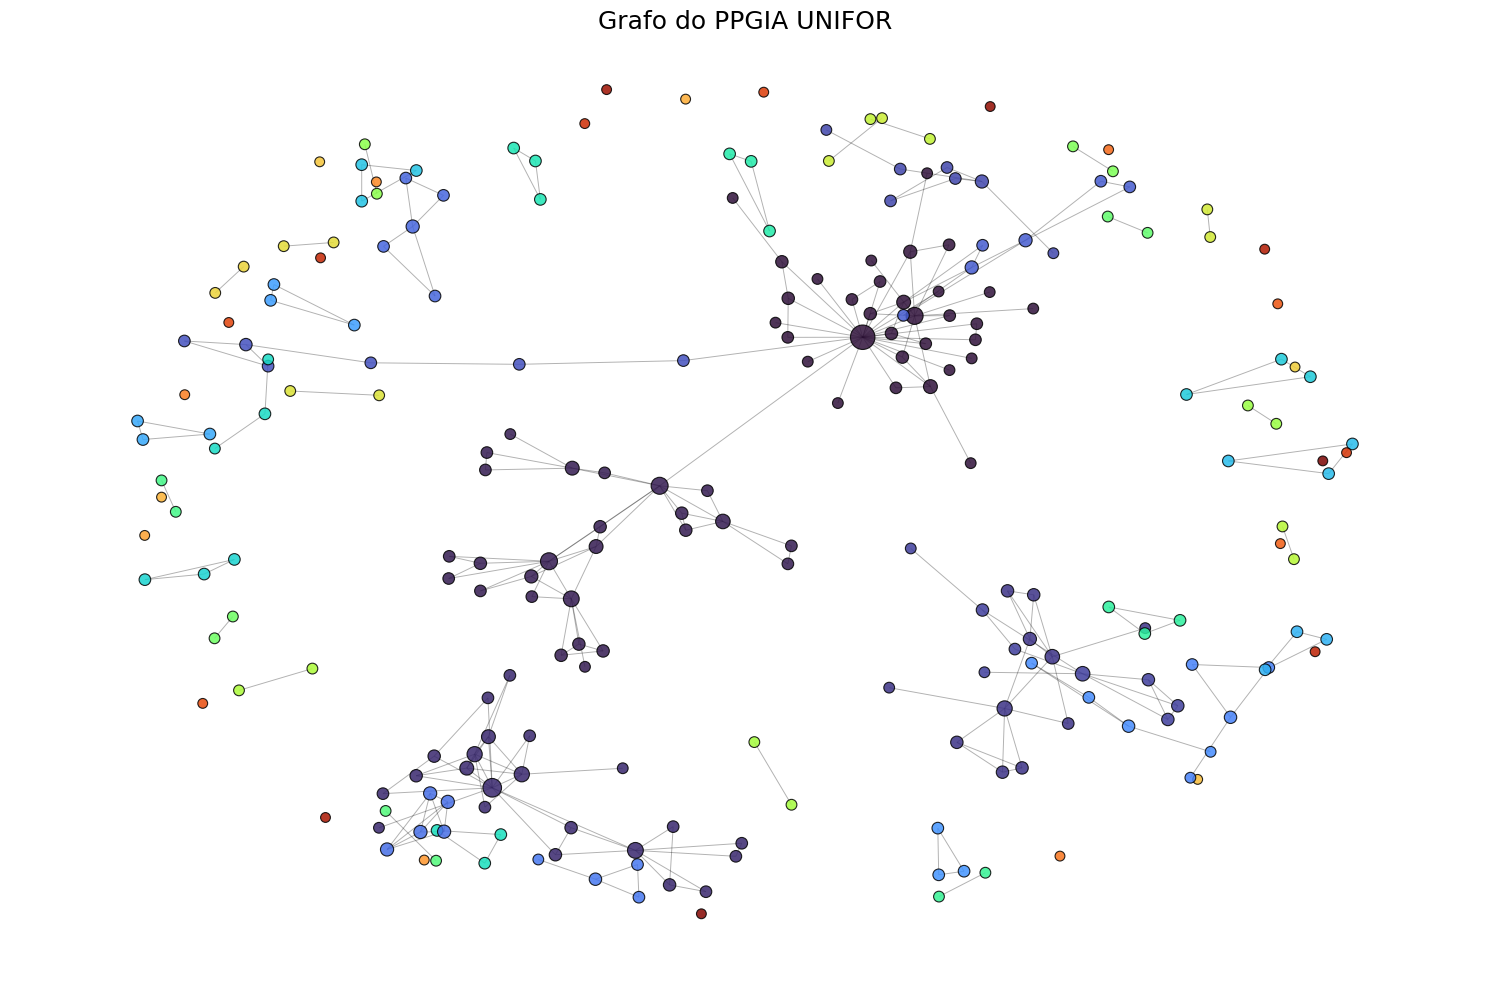

In [232]:
# Baixando arquivo
!gdown 1O1iRB19mGlX7D_AL9P3kYgjbvuCLmznV

# Caminho do arquivo
arquivo = "grafo_coautoria_ppgia_unifor.graphml"

# Carrega o grafo
G = nx.read_graphml(arquivo)
no_alvo = 'YR Serpa'

G.remove_edge(no_alvo, no_alvo)

# G.add_edge('YR Serpa', 'YR Serpa', weight=-1)
nodes_para_excluir = [str(x) for x in range(1900,2026)]
G.remove_nodes_from(nodes_para_excluir)

# Tratando os nomes
data = nx.to_pandas_adjacency(G)
data.index = data.index.astype(str).str.upper()
data.columns = data.columns.astype(str).str.upper()
data = normalizar_e_agrupar_com_cedilha(data)

for _ in range(2):
    lista_excluir = []
    for x in data.index:
        try:
            nome = x
            if '-' in nome:
                nome = nome.split('-')[0]
                nome = nome.replace(' …', '')
                nome = nome.replace('…', '')
                nome = nome.strip()

                # Cria linha/coluna se ainda não existe
                if nome not in data.index:
                    data.loc[nome] = 0
                    data[nome] = 0

                # Soma as contribuições
                data.loc[nome] += data.loc[x]
                data[nome] += data[x]

                lista_excluir.append(x)
        except Exception as e:
            print(f"Erro ao processar '{x}': {e}")
            continue

    try:
        data = data.drop(columns=lista_excluir)
        data = data.drop(index=lista_excluir)
        print(f"Removidos: {lista_excluir}")
    except Exception as e:
        print(f"Erro ao remover: {e}")

# === NOVO BLOCO: Remoção segura de duplicatas ===

# Verifica colunas/índices duplicados e mantém o de menor posição
duplicadas = data.columns[data.columns.duplicated()].unique()

for nome in duplicadas:
    # Pega todas as colunas duplicadas com esse nome
    colunas_iguais = data.loc[:, data.columns == nome]

    # Verifica se todas as colunas têm o mesmo conteúdo
    iguais = colunas_iguais.eq(colunas_iguais.iloc[:, 0], axis=0).all().all()

    if not iguais:
        print(f"[AVISO] Colunas duplicadas com nome '{nome}' possuem dados diferentes. Mantendo a primeira ocorrência.")

    # Mantém apenas a primeira
    primeira_coluna = colunas_iguais.iloc[:, 0]
    data = data.drop(columns=colunas_iguais.columns[1:])  # Remove as demais
    data[nome] = primeira_coluna  # Garante que a primeira permaneça (redundante, mas seguro)

# Repete o processo para o índice
duplicados_idx = data.index[data.index.duplicated()].unique()

for nome in duplicados_idx:
    linhas_iguais = data.loc[data.index == nome]

    iguais = linhas_iguais.eq(linhas_iguais.iloc[0], axis=1).all().all()

    if not iguais:
        print(f"[AVISO] Linhas duplicadas com nome '{nome}' possuem dados diferentes. Mantendo a primeira ocorrência.")

    # Mantém a primeira
    primeira_linha = linhas_iguais.iloc[0]
    data = data.drop(index=linhas_iguais.index[1:])  # Remove as demais
    data.loc[nome] = primeira_linha  # Garante que a primeira permaneça

data = data.loc[~data.columns.duplicated(), ~data.index.duplicated()]

G = nx.from_pandas_adjacency(data, create_using=nx.Graph())
# Exibe informações básicas
print("Número de nós:", G.number_of_nodes())
print("Número de arestas:", G.number_of_edges())

plotar_grafo_legivel(G,'Grafo do PPGIA UNIFOR')

# Passo 02
 Implementação ou Uso de Bibliotecas:
* Implementar os algoritmos para calcular cada uma das medidas de
centralidade mencionadas.  
* Pode-se utilizar bibliotecas de análise de grafos em linguagens como
Python (NetworkX, igraph) que já possuem implementações eficientes
dessas medidas.  
* Aplicar as funções implementadas ou das bibliotecas para calcular todas as seis
medidas de centralidade para cada pesquisador no grafo de colaboração.

1. Degree Centrality (Centralidade de Grau)
- O que mede: Quantas conexões diretas (arestas) um nó tem.

In [233]:
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

print("Top 15 nós por Degree Centrality (normalizada):")
print("-------------------------------------------------")
print(f"{'Rank':<5} | {'Nó':<5} | {'Degree Centrality':<20}")
print("-------------------------------------------------")

num_nodes_to_print = min(15, len(sorted_degree_centrality))
for i in range(num_nodes_to_print):
    node, centrality = sorted_degree_centrality[i]
    print(f"{i+1:<5} | {node:<5} | {centrality:<20.4f}")

Top 15 nós por Degree Centrality (normalizada):
-------------------------------------------------
Rank  | Nó    | Degree Centrality   
-------------------------------------------------
1     | MAF RODRIGUES | 0.1092              
2     | JJPC RODRIGUES | 0.0546              
3     | YR SERPA | 0.0420              
4     | A SAMPAIO | 0.0420              
5     | NC MENDONCA | 0.0420              
6     | N MENDONCA | 0.0336              
7     | A BRAYNER | 0.0336              
8     | RH FILHO | 0.0294              
9     | C CAMINHA | 0.0294              
10    | JVV SOBRAL | 0.0294              
11    | V FURTADO | 0.0252              
12    | PHM MAIA | 0.0252              
13    | VHC DE ALBUQUERQUE | 0.0252              
14    | CM ADERALDO | 0.0210              
15    | HP PONTES | 0.0210              


- Degree sem a normalização

In [234]:
dicio = dict(G.degree())
sorted_degree_centrality = sorted(dicio.items(), key=lambda item: item[1], reverse=True)
print("Top 15 nós por Degree Centrality (normalizada):")
print("-------------------------------------------------")
print(f"{'Rank':<5} | {'Nó':<5} | {'Degree Centrality':<20}")
print("-------------------------------------------------")

num_nodes_to_print = min(15, len(sorted_degree_centrality))
for i in range(num_nodes_to_print):
    node, centrality = sorted_degree_centrality[i]
    print(f"{i+1:<5} | {node:<5} | {centrality:<20.4f}")

Top 15 nós por Degree Centrality (normalizada):
-------------------------------------------------
Rank  | Nó    | Degree Centrality   
-------------------------------------------------
1     | MAF RODRIGUES | 26.0000             
2     | JJPC RODRIGUES | 13.0000             
3     | YR SERPA | 10.0000             
4     | A SAMPAIO | 10.0000             
5     | NC MENDONCA | 10.0000             
6     | N MENDONCA | 8.0000              
7     | A BRAYNER | 8.0000              
8     | RH FILHO | 7.0000              
9     | C CAMINHA | 7.0000              
10    | JVV SOBRAL | 7.0000              
11    | V FURTADO | 6.0000              
12    | PHM MAIA | 6.0000              
13    | VHC DE ALBUQUERQUE | 6.0000              
14    | CM ADERALDO | 5.0000              
15    | HP PONTES | 5.0000              


2. Closeness Centrality (Centralidade de Proximidade)
- O que mede: Quão perto (em termos de caminhos) um nó está de todos os outros.

In [235]:
closeness_scores = nx.closeness_centrality(G)
sorted_degree_centrality = sorted(closeness_scores.items(), key=lambda item: item[1], reverse=True)

print("Top 15 nós por Degree Centrality (normalizada):")
print("-------------------------------------------------")
print(f"{'Rank':<5} | {'Nó':<5} | {'Degree Centrality':<20}")
print("-------------------------------------------------")

num_nodes_to_print = min(15, len(sorted_degree_centrality))
for i in range(num_nodes_to_print):
    node, centrality = sorted_degree_centrality[i]
    print(f"{i+1:<5} | {node:<5} | {centrality:<20.4f}")

Top 15 nós por Degree Centrality (normalizada):
-------------------------------------------------
Rank  | Nó    | Degree Centrality   
-------------------------------------------------
1     | MAF RODRIGUES | 0.1361              
2     | NC MENDONCA | 0.1212              
3     | YR SERPA | 0.1000              
4     | HP PONTES | 0.0995              
5     | DV MACEDO | 0.0985              
6     | VM CARVALHO | 0.0976              
7     | JH FONTELES | 0.0971              
8     | PPM NETO | 0.0966              
9     | DV DE MACEDO | 0.0966              
10    | RG BARBOSA | 0.0962              
11    | A SAMPAIO | 0.0957              
12    | PATTERNS AND … | 0.0953              
13    | EF DUTRA | 0.0944              
14    | TRC DE OLIVEIRA | 0.0944              
15    | ES SILVA | 0.0939              


3. Betweenness Centrality (Centralidade de Intermediação)
- O que mede: Quantos caminhos mais curtos entre pares de nós passam por esse nó.

In [236]:
betweenness_scores = nx.betweenness_centrality(G)
sorted_degree_centrality = sorted(betweenness_scores.items(), key=lambda item: item[1], reverse=True)

print("Top 15 nós por Degree Centrality (normalizada):")
print("-------------------------------------------------")
print(f"{'Rank':<5} | {'Nó':<5} | {'Degree Centrality':<20}")
print("-------------------------------------------------")

num_nodes_to_print = min(15, len(sorted_degree_centrality))
for i in range(num_nodes_to_print):
    node, centrality = sorted_degree_centrality[i]
    print(f"{i+1:<5} | {node:<5} | {centrality:<20.4f}")

Top 15 nós por Degree Centrality (normalizada):
-------------------------------------------------
Rank  | Nó    | Degree Centrality   
-------------------------------------------------
1     | MAF RODRIGUES | 0.0667              
2     | NC MENDONCA | 0.0456              
3     | A SAMPAIO | 0.0173              
4     | HP PONTES | 0.0134              
5     | VM CARVALHO | 0.0113              
6     | N MENDONCA | 0.0094              
7     | JBF DUARTE | 0.0092              
8     | ES FURTADO | 0.0092              
9     | YR SERPA | 0.0087              
10    | CM ADERALDO | 0.0071              
11    | APF BASTOS | 0.0070              
12    | M CUNHA | 0.0061              
13    | JJPC RODRIGUES | 0.0052              
14    | PHM MAIA | 0.0048              
15    | E FURTADO | 0.0048              


4. Eigenvector Centrality (Centralidade de Autovetor)
- O que mede: Importância de um nó levando em conta a importância dos seus vizinhos.

In [237]:
eigenvector_scores = nx.eigenvector_centrality(G, max_iter=1000, tol=1.0e-6)
sorted_degree_centrality = sorted(eigenvector_scores.items(), key=lambda item: item[1], reverse=True)

print("Top 15 nós por Degree Centrality (normalizada):")
print("-------------------------------------------------")
print(f"{'Rank':<5} | {'Nó':<5} | {'Degree Centrality':<20}")
print("-------------------------------------------------")

num_nodes_to_print = min(15, len(sorted_degree_centrality))
for i in range(num_nodes_to_print):
    node, centrality = sorted_degree_centrality[i]
    print(f"{i+1:<5} | {node:<5} | {centrality:<20.4f}")

Top 15 nós por Degree Centrality (normalizada):
-------------------------------------------------
Rank  | Nó    | Degree Centrality   
-------------------------------------------------
1     | MAF RODRIGUES | 0.6169              
2     | YR SERPA | 0.2908              
3     | JH FONTELES | 0.2121              
4     | RG BARBOSA | 0.1872              
5     | DV MACEDO | 0.1803              
6     | NC MENDONCA | 0.1800              
7     | HP PONTES | 0.1708              
8     | PPM NETO | 0.1693              
9     | DV DE MACEDO | 0.1532              
10    | PATTERNS AND … | 0.1517              
11    | EF DUTRA | 0.1464              
12    | ES SILVA | 0.1385              
13    | TRC DE OLIVEIRA | 0.1312              
14    | EBS LUSTOSA | 0.1287              
15    | PF LINHARES | 0.1276              


5. Katz Centrality
- O que mede: Importância de um nó levando em conta todas as conexões, diretas e indiretas, com decaimento exponencial para conexões distantes.

In [238]:
katz_scores = nx.katz_centrality(G, beta=1.0, normalized=True, max_iter=1000, tol=1.0e-6)
sorted_degree_centrality = sorted(katz_scores.items(), key=lambda item: item[1], reverse=True)

print("Top 15 nós por Degree Centrality (normalizada):")
print("-------------------------------------------------")
print(f"{'Rank':<5} | {'Nó':<5} | {'Degree Centrality':<20}")
print("-------------------------------------------------")

num_nodes_to_print = min(15, len(sorted_degree_centrality))
for i in range(num_nodes_to_print):
    node, centrality = sorted_degree_centrality[i]
    print(f"{i+1:<5} | {node:<5} | {centrality:<20.4f}")

Top 15 nós por Degree Centrality (normalizada):
-------------------------------------------------
Rank  | Nó    | Degree Centrality   
-------------------------------------------------
1     | MAF RODRIGUES | 0.2618              
2     | JJPC RODRIGUES | 0.1479              
3     | NC MENDONCA | 0.1430              
4     | YR SERPA | 0.1388              
5     | A SAMPAIO | 0.1245              
6     | JVV SOBRAL | 0.1071              
7     | RH FILHO | 0.1053              
8     | JH FONTELES | 0.1050              
9     | N MENDONCA | 0.1042              
10    | A BRAYNER | 0.1022              
11    | HP PONTES | 0.0995              
12    | RAL RABELO | 0.0956              
13    | M CUNHA | 0.0956              
14    | HS ARAUJO | 0.0943              
15    | PPM NETO | 0.0942              


# Análise e Comparação dos Resultados:
- Vale salientar que as conclusões tiradas aqui são com base no dataset que avaliou serca de 130 artigos e que para ter uma conclusão mais realista, séria necessário uma quantidade maior de artigos.

## Degree Centrality:
- A partir do Degree Centrality encontramos que o autor com maior número de ligação é o professora MAF Rodrigues. A professora se destaca na rede por possuir o maior número de conexões diretas, totalizando 26. Essa métrica elevada é um forte indicador de que ela desempenha um papel ativo e central em colaborações, desenvolvendo projetos e estudos com um número significativamente maior de indivíduos dentro desta rede em comparação com os demais

## Closeness Centrality
- A partir da análise utilizando o algoritmo de Closeness Centrality, identificamos que a professora MAF. Rodrigues ocupa a posição de maior centralidade de proximidade no grafo. Isso significa que, em média, ela está a uma distância mais curta de todos os outros autores da rede. Em termos práticos, essa métrica sugere que a professora possui fácil acesso a qualquer outro pesquisador da rede, sendo uma ponte eficiente entre diferentes partes do grafo. Consequentemente, pesquisadores conectados a ela tendem a estar mais próximos dos demais, o que pode facilitar a disseminação de informações, colaborações e influência acadêmica.



## Betweenness Centrality
* Ao aplicar a Betweenness Centrality no grafo, identificamos que o professor MAF Rodrigues é o nó com a maior centralidade de intermediação, ou seja, é aquele que mais aparece nos caminhos mais curtos entre outros pares de nós.

* Isso indica que ele tem um papel estratégico na rede: atua como uma ponte entre diferentes partes do grafo, facilitando a comunicação e a conexão entre professores.

* Ele não necessariamente tem mais conexões diretas, mas é crucial para o fluxo de informação e acesso indireto. Professores que não estão diretamente conectados entre si muitas vezes passam por ele para se conectarem, o que reforça sua importância estrutural.

## Eigenvector Centrality
- Com base na métrica de Eigenvector Centrality, observamos novamente que a professora MAF Rodrigues se destaca como a autora mais influente da rede. Esse resultado indica que sua importância não se dá apenas pelo número de conexões diretas ou pela proximidade com os demais nós, mas principalmente pela qualidade dessas conexões. Ou seja, ela está conectada a outros autores que também são altamente conectados e influentes, o que amplifica ainda mais sua relevância na estrutura global do grafo. Essa centralidade evidencia um papel de liderança e influência acadêmica significativa dentro da rede de coautorias.

## Katz Centrality
- A análise por meio da Katz Centrality confirmou novamente a posição de destaque da professora MAF Rodrigues na rede de coautorias. Essa métrica leva em consideração não apenas o número de conexões diretas, mas também a influência dos nós aos quais um autor está conectado, atribuindo um peso adicional às conexões indiretas com autores influentes. O fato de a professora liderar também nesse indicador reforça sua posição central e estratégica na rede acadêmica, demonstrando que sua influência se estende além dos vínculos diretos, alcançando de forma relevante diferentes camadas da rede. Isso sugere que ela atua como um importante elo de disseminação de conhecimento e de fortalecimento das colaborações dentro da comunidade científica analisada.

# Plot grafo professora MAF Rodrigues

Plotando o componente conectado de 'MAF RODRIGUES' com 70 nós e 108 arestas.
Layout: spring
  k_spring: 0.5, iterations: 80, scale: 1.8


<ipython-input-201-a9c3bf691e0b>:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = plt.cm.get_cmap(other_node_community_cmap, num_comunidades if num_comunidades > 1 else 2)


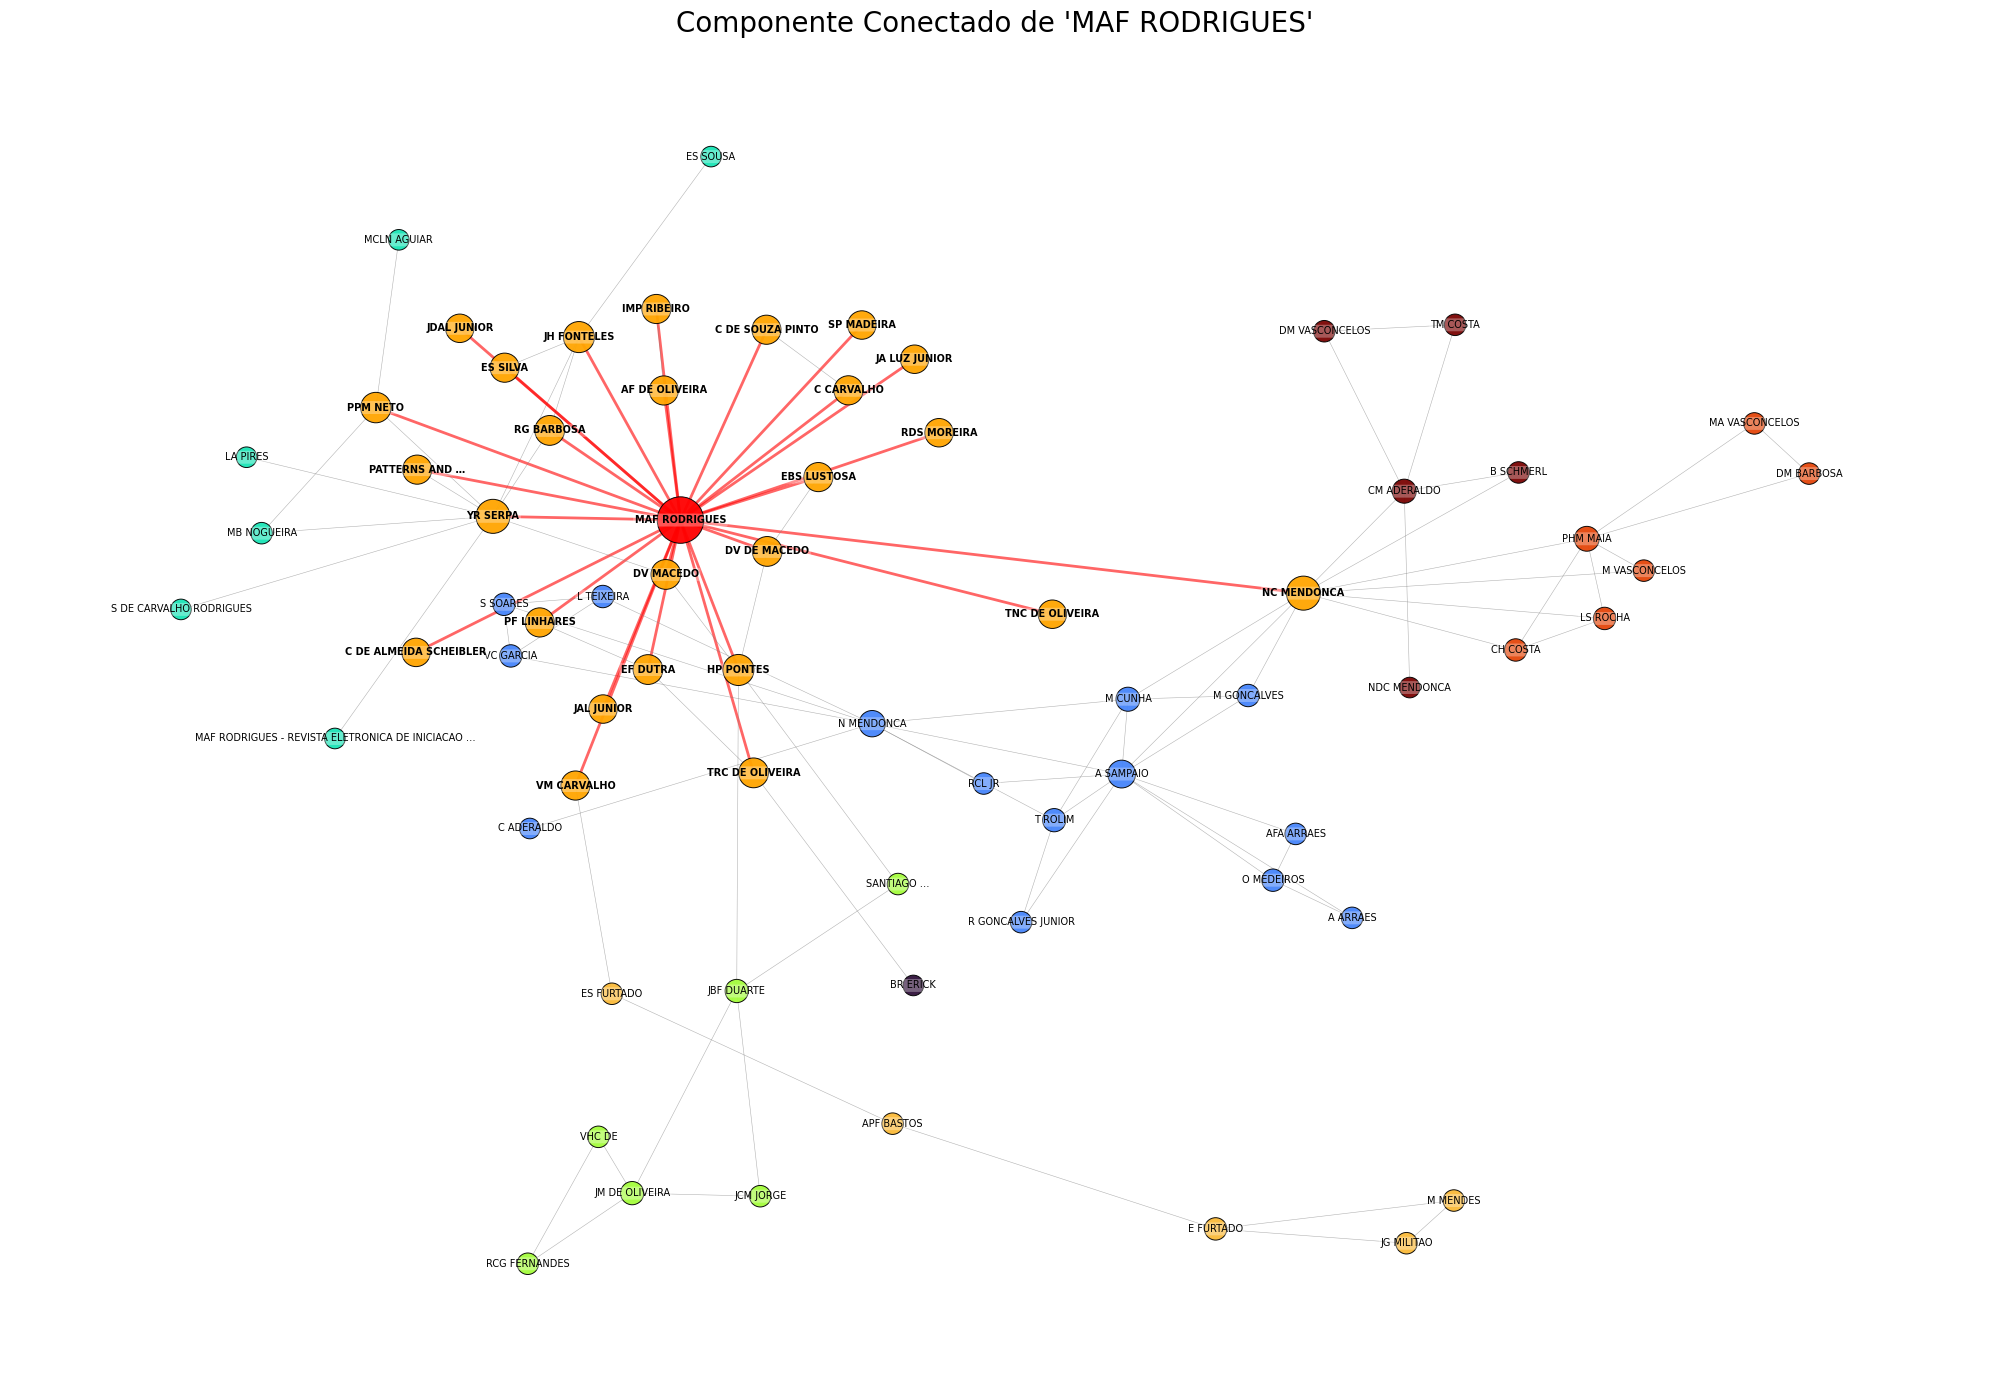

In [239]:
plotar_componente_conectado_com_destaque(G,'MAF RODRIGUES')

# Plot das conexões do professor Raimir

Plotando o componente conectado de 'RH FILHO' com 22 nós e 40 arestas.
Layout: spring
  k_spring: 0.5, iterations: 80, scale: 1.8


<ipython-input-201-a9c3bf691e0b>:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = plt.cm.get_cmap(other_node_community_cmap, num_comunidades if num_comunidades > 1 else 2)


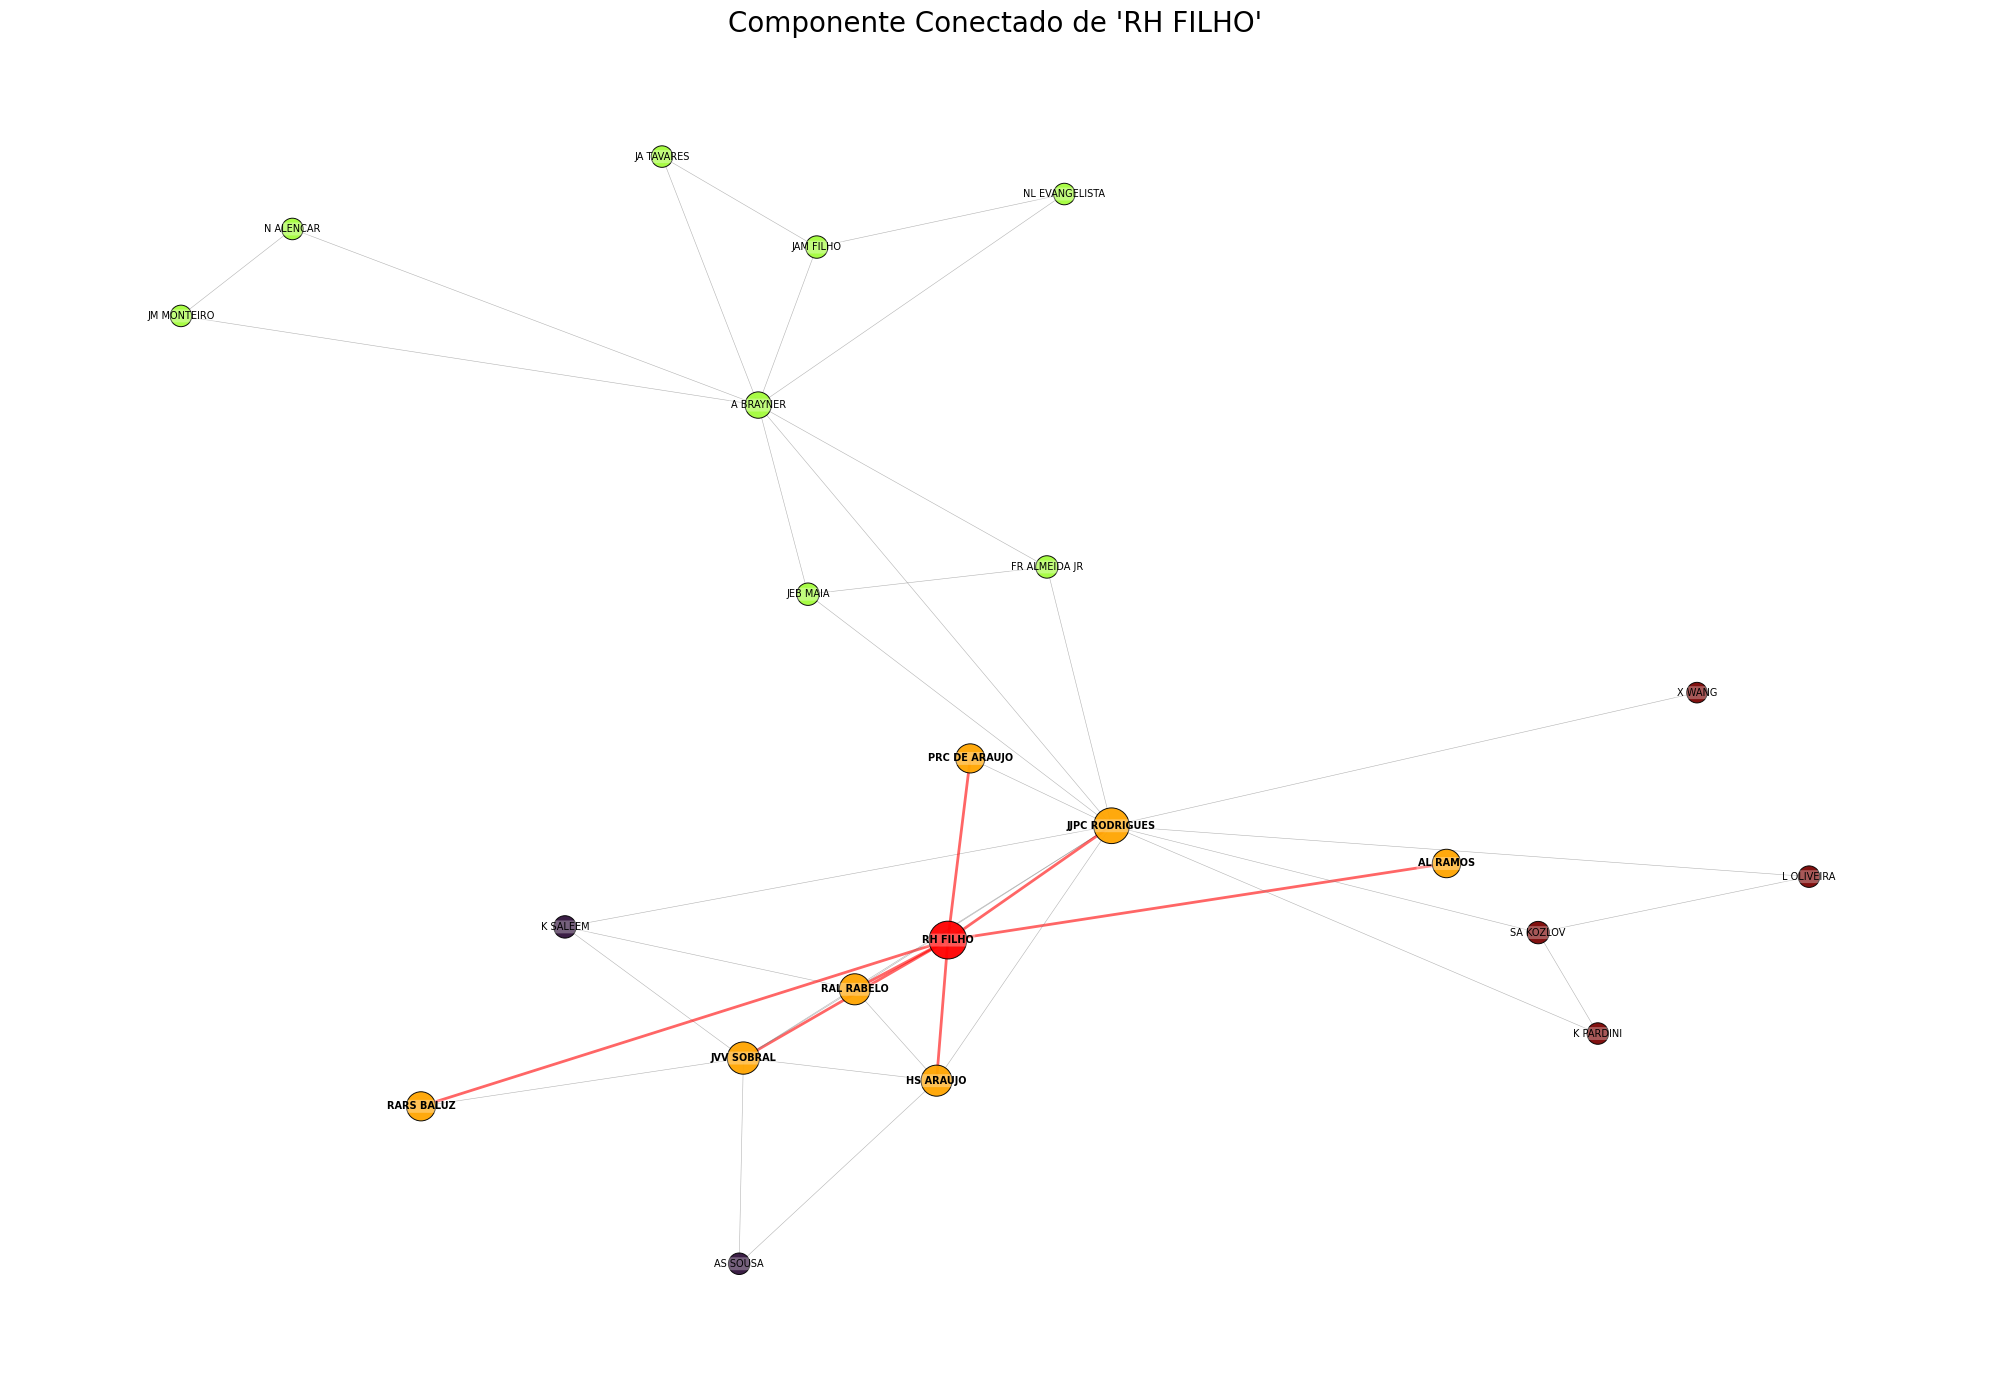

In [243]:
plotar_componente_conectado_com_destaque(G,'RH FILHO')

# Grafo completo

Plotando grafo 'Visualização de Grafo' com 239 nós e 267 arestas.
Layout: spring
  k_spring: 0.5, iterations: 80, scale: 1.8


<ipython-input-244-d57ed5db2609>:674: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nodes = plt.cm.get_cmap('turbo', num_comunidades_detected if num_comunidades_detected > 1 else 2)


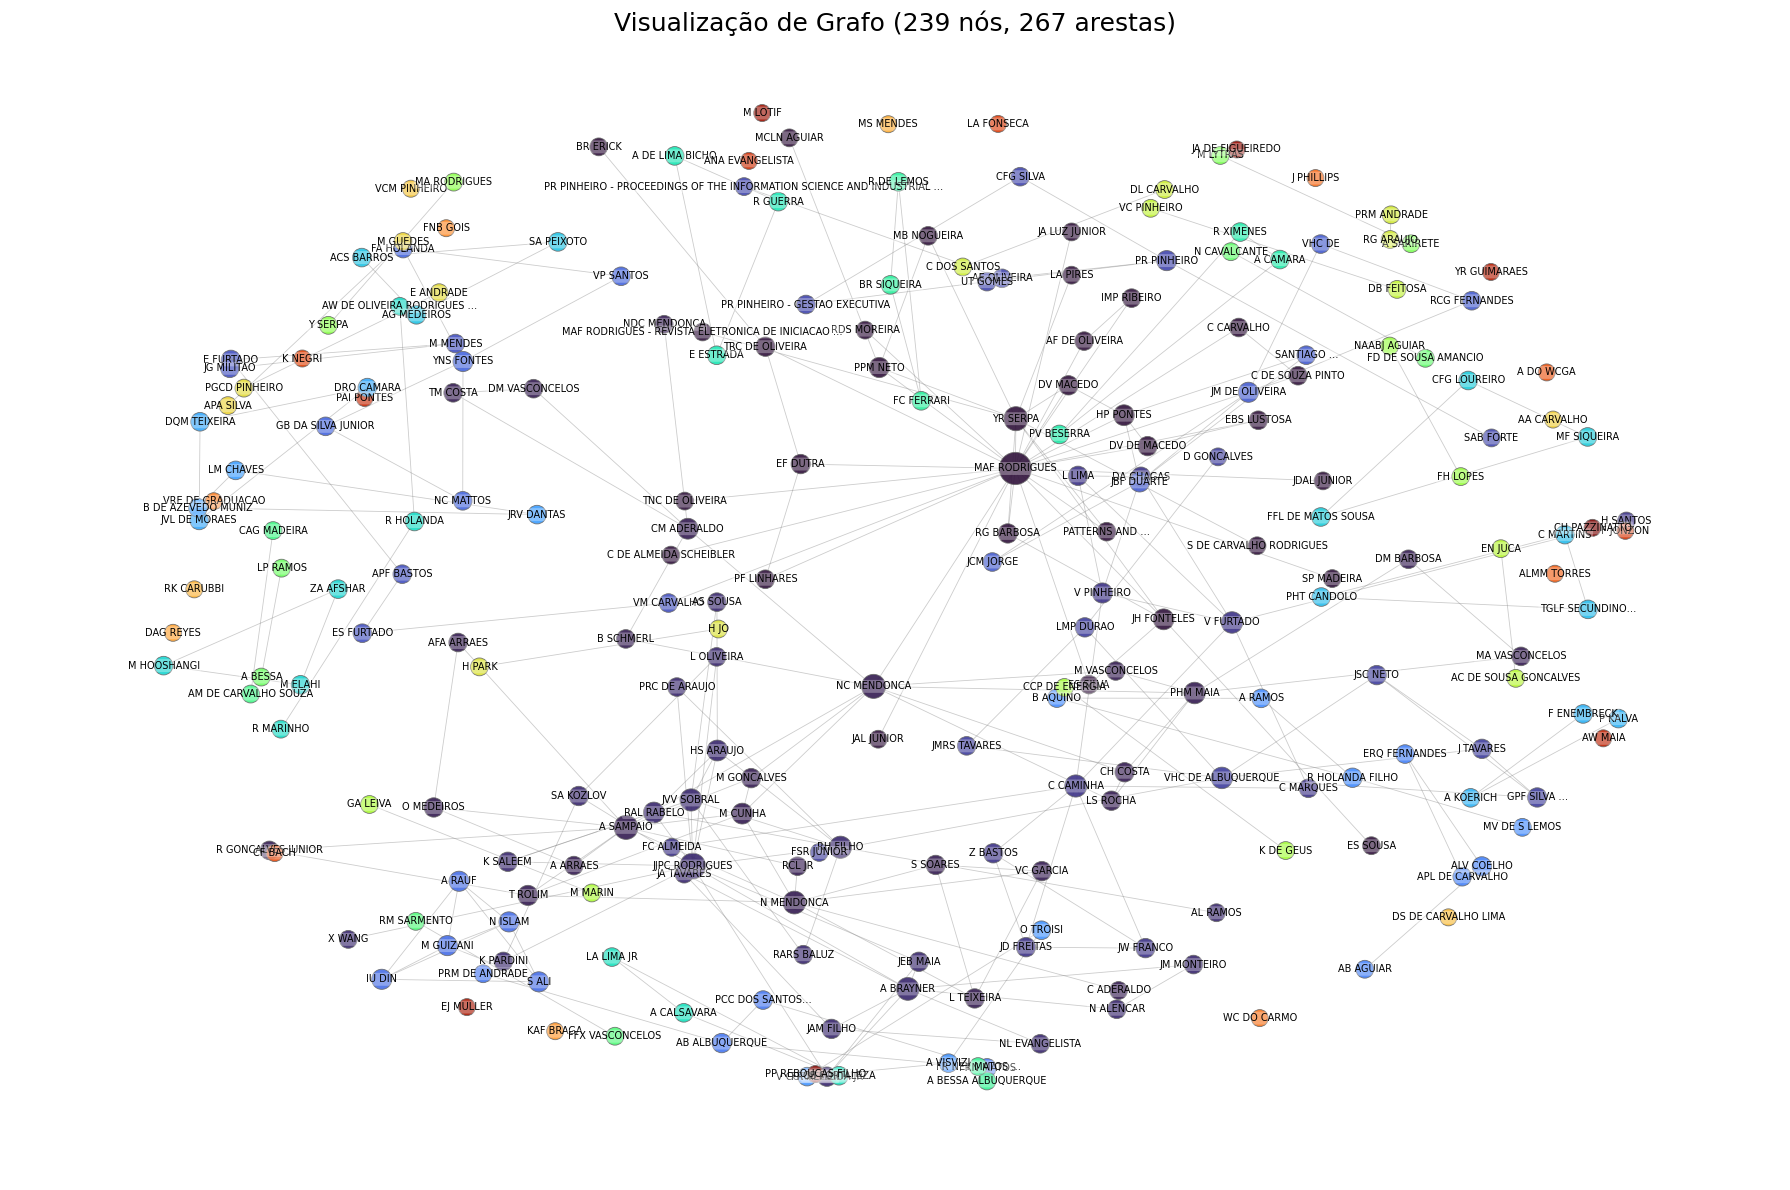

In [245]:
plotar_grafo_legivel(G)